<a href="https://colab.research.google.com/github/lifeisbeautifu1/deep-learning/blob/main/Makemore%20(Activations%2C%20Gradients%20%26%20BatchNorm).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Building makemore with Andrej Karpathy
https://www.youtube.com/watch?v=P6sfmUTpUmc&t=113s

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import requests

from pathlib import Path
if Path("names.txt").is_file():
  print(f"names.txt already downloaded")
else:
  print("Downloading names.txt")
  request = requests.get("https://raw.githubusercontent.com/karpathy/makemore/master/names.txt")
  with open("names.txt", 'wb') as f:
    f.write(request.content)

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set("".join(words))))
stoi = { s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = { i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# build the dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [15]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) * ((n_embd * block_size) ** 0.5)#0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.rand(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum((p.nelement() for p in parameters)))
for p in parameters:
  p.requires_grad = True

12297


In [16]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1

  # normalization
  hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
  hpreact =  bngain * hpreact + bnbias

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.2977
  10000/ 200000: 2.0181
  20000/ 200000: 1.9452
  30000/ 200000: 2.3875
  40000/ 200000: 2.2199
  50000/ 200000: 2.4370
  60000/ 200000: 2.0244
  70000/ 200000: 1.8198
  80000/ 200000: 2.2840
  90000/ 200000: 2.2094
 100000/ 200000: 2.2416
 110000/ 200000: 2.3678
 120000/ 200000: 1.8558
 130000/ 200000: 2.2873
 140000/ 200000: 2.3403
 150000/ 200000: 2.4139
 160000/ 200000: 2.3414
 170000/ 200000: 1.6990
 180000/ 200000: 2.0916
 190000/ 200000: 2.1589


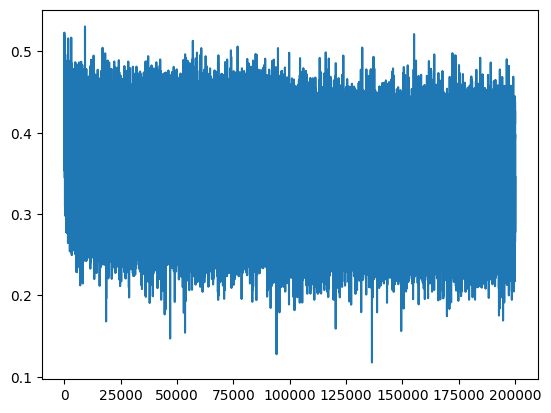

In [17]:
plt.plot(lossi)

In [18]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      "train": (Xtr, Ytr),
      "val": (Xdev, Ydev),
      "test": (Xte, Yte)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
  hpreact =  bngain * hpreact + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.1735899448394775
val 2.187839984893799


In [12]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    # forward pass
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)

    ix = torch.multinomial(probs, num_samples=1, generator=g).item()

    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
      break
  print("".join(itos[i] for i in out))

mora.
mayah.
see.
mad.
rylloren.
ruthadrie.
cadelyn.
elin.
shi.
jen.
edeiseanana.
septyion.
kamin.
shubergianaiya.
kinde.
jennex.
teron.
ububynder.
yarue.
els.
